In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG=True

import numpy as np
import numpy.linalg as LA
import networkx as nx
import os
import pickle
import matplotlib.pyplot as plt
from itertools import combinations


Bad key "text.kerning_factor" on line 4 in
C:\Users\SRV DATOS\miniconda3\envs\pharmacophore\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [11]:
def bin_distance(distance, bin_size=1):
    """Group distances into bins defined by bin_size"""
    bins = np.arange(21, step=bin_size)
    last_bin = bins[distance > bins][-1]
    
    if distance == last_bin:
        binned_distance = last_bin
    elif distance >= last_bin + bin_size/2:
        binned_distance = last_bin + bin_size
    elif distance < last_bin + bin_size/2:
        binned_distance = last_bin

    return binned_distance

def distance_between_pharmacophore_points(p1_coords, p2_coords):
    """Computes the distance between pharmacophore points or edges in a conformer graph"""
    
    vector = p2_coords - p1_coords #vector between the two points
    distance = LA.norm(vector)
    
    return distance

def feature_centroid(molecule, conformer_idx, atom_indxs):
    """Get the 3D coordinates of the centroid of a feature that encompasses
       more than one atom. This could be aromatic, hydrophobic, negative and positive 
    """
    
    n_atoms = len(atom_indxs)
    coords = np.zeros((n_atoms, 3))
    for j, idx in enumerate(atom_indxs):
            position = molecule.GetConformer(conformer_idx).GetAtomPosition(idx)
            coords[j, 0] = position.x
            coords[j, 1] = position.y
            coords[j, 2] = position.z
    
    centroid = coords.mean(axis=0)
   
    return centroid

def get_rdkit_features(molecule, cf_graph, conformer_idx):
    """Get features from rdkit definition and add them to the graph"""
    
    fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
    factory = ChemicalFeatures.BuildFeatureFactory(fdefName)
    feats = factory.GetFeaturesForMol(molecule)
    
    accepted_feats = ['Acceptor', 'Aromatic']
    
    i = 0
    for feature in feats:
        feat_name = feature.GetFamily()  
        if feat_name not in accepted_feats:
            continue

        atom_idxs = feature.GetAtomIds()

        if len(atom_idxs) > 1: # it's an aromatic feature!
            coords = feature_centroid(molecule, conformer_idx, atom_idxs)
        else:
            position = molecule.GetConformer(conformer_idx).GetAtomPosition(atom_idxs[0])
            coords = np.zeros((3,))
            coords[0] = position.x
            coords[1] = position.y
            coords[2] = position.z
        
        cf_graph.add_node(i, feat_type=feat_name, coordinates=coords)
        i += 1

def get_smarts_features(molecule, cf_graph, conformer_idx):
    
    with open('./data/smarts_feats', 'rb') as f:
        feats_dict = pickle.load(f)
    
    i = 0
    for feat, feat_type in feats_dict.items():
        pattern = Chem.MolFromSmarts(feat)  
        atom_idxs = molecule.GetSubstructMatch(pattern)
        if len(atom_idxs) == 0:
            continue
        
        if len(atom_idxs) == 1: # Donor or acceptor feature
            position = molecule.GetConformer(conformer_idx).GetAtomPosition(atom_idxs[0])
            coords = np.zeros((3,))
            coords[0] = position.x
            coords[1] = position.y
            coords[2] = position.z
        else: # Aromatic, hydrophobic, positive or negative
            coords = feature_centroid(molecule, conformer_idx, atom_idxs)
        
        cf_graph.add_node(i, feat_type=feat_type, coordinates=coords)
        i += 1

        
def conformer_graph(molecule, conformer_idx, features='rdkit'):
    
    cf_graph = nx.MultiGraph()
    
    # Create the graph nodes or pharmacophore points
    if features == 'rdkit':
        get_rdkit_features(molecule, cf_graph, conformer_idx)
    elif features == 'smarts':
        get_smarts_features(molecule, cf_graph, conformer_idx)
    
    # Add edges 
    points = list(cf_graph.nodes())
    for pi, pj in combinations(points, 2): #combinations between all pharmacophore points
        pi_coords = cf_graph.nodes[pi]['coordinates']
        pj_coords = cf_graph.nodes[pj]['coordinates']
        distance = distance_between_pharmacophore_points(pi_coords, pj_coords)
        # print(distance)
        if distance > 0:
            binned_distance = bin_distance(distance, bin_size=1)
            cf_graph.add_edge(pi, pj, distance=binned_distance)

            
    # TODO: when distance is 0 a point has two features, however it is being currently displayed
    # as two different nodes.
    
    return cf_graph



5 molecules


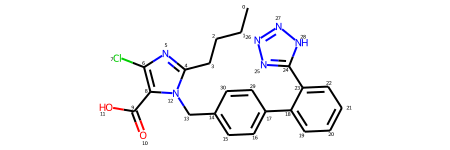

In [2]:
# Load inhibitors from smi file 
molecules = Chem.SmilesMolSupplier('./data/clique/molecules.smi',delimiter='\t',titleLine=False)
print(f"{len(molecules)} molecules")
# Visualize first molecule
molecules[0]

In [12]:
def generate_conformers(molecule, n_conformers):
    """Generate n conformers for a molecule"""
    molecule = Chem.AddHs(molecule) # Add hydrogens to generate realistic geometries
    cids = AllChem.EmbedMultipleConfs(molecule, numConfs=10)
    AllChem.AlignMolConformers(molecule)
    
    return molecule

graphs = []
i = 0
for mol in molecules:
    mol = generate_conformers(mol, 10)
    cf_graph = conformer_graph(mol, 0, features='smarts')
    graphs.append(cf_graph)
    print(f"Molecule {i} has {len(cf_graph.nodes())} pharmacophore points")
    print(f"Number of edges: {len(cf_graph.edges())}\n")
    i += 1

Molecule 0 has 9 pharmacophore points
Number of edges: 36

Molecule 1 has 9 pharmacophore points
Number of edges: 35

Molecule 2 has 9 pharmacophore points
Number of edges: 35

Molecule 3 has 9 pharmacophore points
Number of edges: 35

Molecule 4 has 9 pharmacophore points
Number of edges: 35



In [14]:
graphs[2].nodes(data=True)

NodeDataView({0: {'feat_type': 'a', 'coordinates': array([ 1.62920814, -0.47365304,  0.23732627])}, 1: {'feat_type': 'a', 'coordinates': array([-2.82758265, -1.14087584, -0.67351706])}, 2: {'feat_type': 'D', 'coordinates': array([3.19941085, 2.19517234, 1.86014855])}, 3: {'feat_type': 'D', 'coordinates': array([-1.43029777, -4.285528  , -1.22706982])}, 4: {'feat_type': 'A', 'coordinates': array([-3.70925598, -0.50492319, -0.88028391])}, 5: {'feat_type': 'A', 'coordinates': array([-1.43029777, -4.285528  , -1.22706982])}, 6: {'feat_type': 'H', 'coordinates': array([-6.07147176,  2.79814647,  0.32752111])}, 7: {'feat_type': 'H', 'coordinates': array([-5.73035824,  2.1154226 ,  0.43403435])}, 8: {'feat_type': 'H', 'coordinates': array([-4.22271726,  1.194695  ,  1.02275029])}})

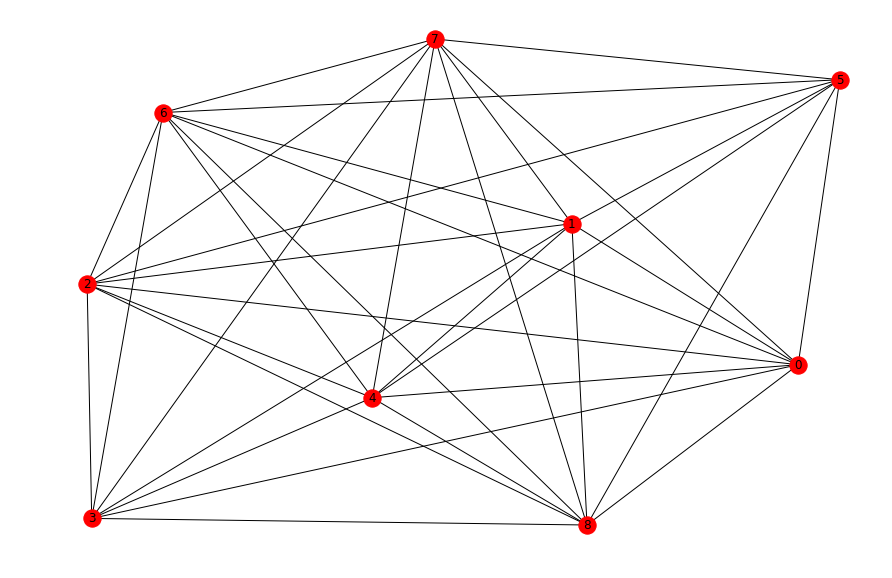

In [15]:
fig, ax = plt.subplots(figsize=(15,10))
nx.draw(graphs[2], with_labels=True, ax=ax)
plt.show()